# PDEs & UFL 1: 


##Advection-Diffusion  

A PDE is converted to an integral which is called the form. To write those forms in FEniCSx, there is a language called Unified Form Language.

For Reading more about it: 

https://fenics.readthedocs.io/projects/ufl/en/latest/


---



## Method of Manufactured Solutions

Starting with a solution, A problem is created and solved again

I will give you another solution and you should construct the problem and solve it.

In [ ]:
#please run twice
try:
    import dolfinx
except ImportError:
    !wget "https://github.com/fem-on-colab/fem-on-colab.github.io/raw/9b21f39/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

In [2]:
import pyvista

In [ ]:
!apt-get install -qq xvfb libgl1-mesa-glx
!pip install pyvista -qq

pyvista.global_theme.jupyter_backend = 'static'
pyvista.global_theme.notebook = True

In [43]:
import numpy as np
from dolfinx.fem import (Constant, Function, FunctionSpace, 
                         assemble_scalar, dirichletbc, form, locate_dofs_geometrical)
from dolfinx import mesh
import dolfinx.fem as fem
from dolfinx.fem.petsc import LinearProblem
from dolfinx.mesh import create_unit_square
from mpi4py import MPI
from petsc4py.PETSc import ScalarType
from ufl import SpatialCoordinate, TestFunction, TrialFunction, dot, ds, dx, grad, exp, as_vector

#Equation 1

## Example 1:


Diffusion-Advection of Temperature

$$\epsilon \nabla^2 T(\vec{x})=\mathbf{\beta}\cdot \nabla T(\vec{x})+q(\vec{x})
$$

$$
T(\vec{x})=1+x+2y
$$


we will solve it in a unit square

use Dirichlet on top, left and bottom

and use Neumann on right boundary

In [44]:
domain=create_unit_square(MPI.COMM_WORLD, 10, 10)
V=FunctionSpace(domain, ("CG", 1))
T = TrialFunction(V)
v = TestFunction(V)
x=SpatialCoordinate(domain)


T_E=1+x[0]+2*x[1]

In [46]:
beta=as_vector((4*x[1]*(1-x[1]),0)) # the vector beta defined using UFL

epsilon=1

from ufl import div, FacetNormal
q=2*div(grad(T_E))-dot(beta,grad(T_E))
# this defines the sum


def boundary_D(x):
    return np.logical_or(np.isclose(x[0], 0), np.isclose(x[1],0),np.isclose(x[1],1))


fdim = domain.topology.dim - 1
boundary_facets = mesh.locate_entities_boundary(domain, fdim, boundary_D)
b_dofs=fem.locate_dofs_topological(V, fdim, boundary_facets)


def T_exact(x):
  return 1+x[0]+2*x[1]

T_Dirichlet=Function(V)
T_Dirichlet.interpolate(T_exact)

bc = dirichletbc(T_Dirichlet, b_dofs)

n = FacetNormal(domain)

g=dot(grad(T_E),n)

In [47]:
from ufl import inner
a=-1*inner(grad(T),grad(v))*dx-dot(grad(T),beta)*v*dx


from petsc4py.PETSc import ScalarType
zero = fem.Constant(domain, ScalarType(0))
L=q*v*dx-g*v*ds


print(type(a))

<class 'ufl.form.Form'>


In [48]:
problem = LinearProblem(a,L,bcs=[bc])
T = problem.solve()

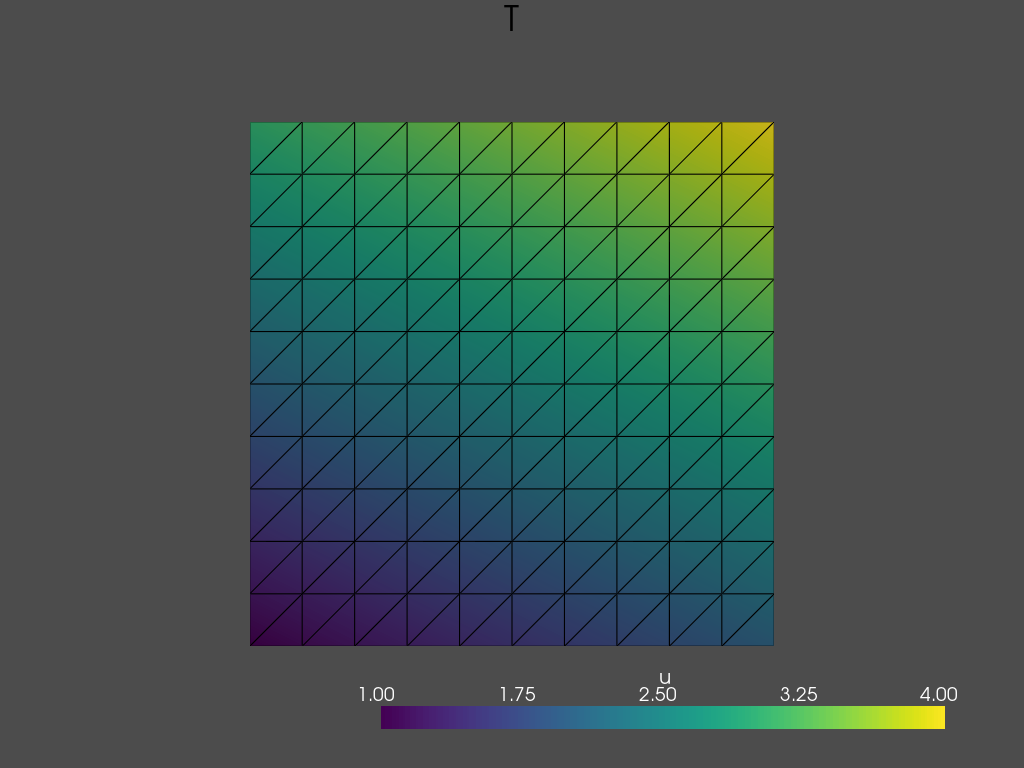

In [49]:
pyvista.start_xvfb()
from dolfinx.plot import create_vtk_mesh
pyvista_cells, cell_types, geometry = create_vtk_mesh(V)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
grid.point_data["u"] = T.x.array
grid.set_active_scalars("u")

plotter = pyvista.Plotter()
plotter.add_text("T", position="upper_edge", font_size=14, color="black")
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()

if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("neumann_dirichlet.png")

## Example 2

$$
\epsilon \nabla^2 T(\vec{x})=\mathbf{\beta}\cdot \nabla T(\vec{x})+q(\vec{x})
$$

$$
T(\vec{x})=(y-\frac{1}{2})^2e^{-x}
$$


we will solve it in a unit square

use Dirichlet on top, left and bottom

and use Neumann on right boundary

In [58]:
domain=create_unit_square(MPI.COMM_WORLD, 10, 10)
V=FunctionSpace(domain, ("CG", 2))
T = TrialFunction(V)
v = TestFunction(V)
x=SpatialCoordinate(domain)
T_E=exp(-1*x[0])*(x[1]-0.5)**2


beta=as_vector((4*x[1]*(1-x[1]),0)) # the vector beta defined using UFL

epsilon=1

from ufl import div, FacetNormal
q=div(grad(T_E))-dot(beta,grad(T_E))
# this defines the sum


def boundary_D(x):
    return np.logical_or(np.isclose(x[0], 0), np.isclose(x[1],0),np.isclose(x[1],1))


fdim = domain.topology.dim - 1
boundary_facets = mesh.locate_entities_boundary(domain, fdim, boundary_D)
b_dofs=fem.locate_dofs_topological(V, fdim, boundary_facets)


def T_exact(x):
  return np.exp(-1*x[0])*np.power(x[1]-0.5,2)

T_Dirichlet=Function(V)
T_Dirichlet.interpolate(T_exact)

bc = dirichletbc(T_Dirichlet, b_dofs)

n = FacetNormal(domain)

g=dot(grad(T_E),n)

from ufl import inner
a=-1*inner(grad(T),grad(v))*dx-dot(grad(T),beta)*v*dx



from petsc4py.PETSc import ScalarType
zero = fem.Constant(domain, ScalarType(0))
L=q*v*dx-g*v*ds


problem = LinearProblem(a,L,bcs=[bc])
T = problem.solve()

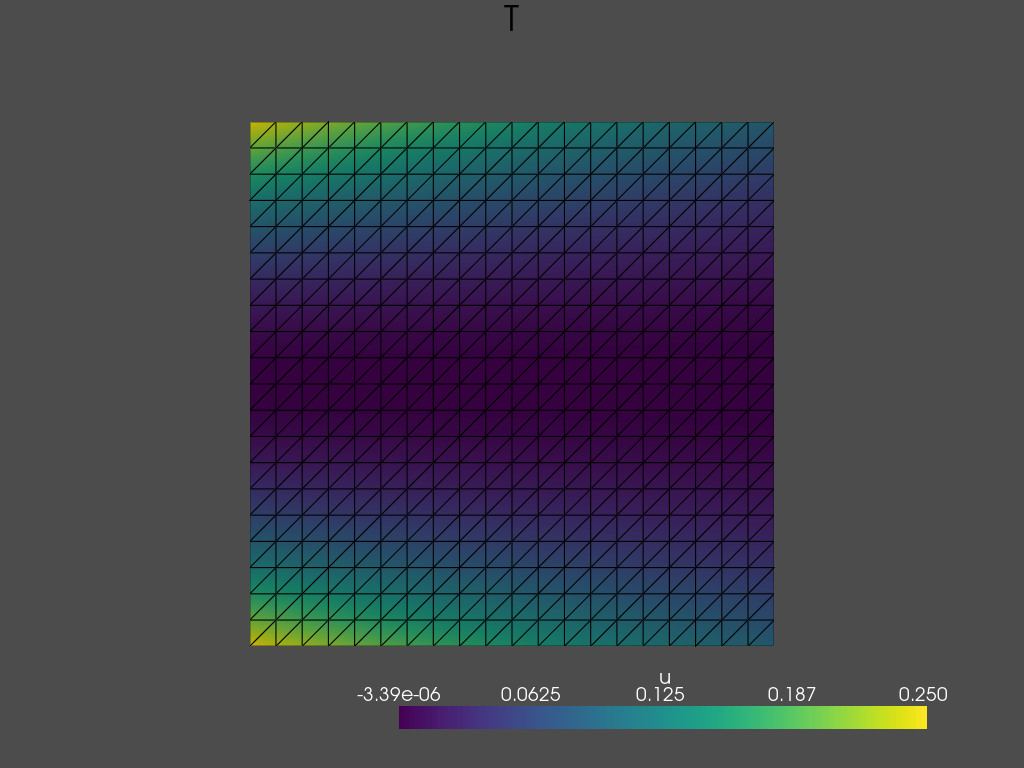

In [59]:
pyvista.start_xvfb()
from dolfinx.plot import create_vtk_mesh
pyvista_cells, cell_types, geometry = create_vtk_mesh(V)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
grid.point_data["u"] = T.x.array
grid.set_active_scalars("u")

plotter = pyvista.Plotter()
plotter.add_text("T", position="upper_edge", font_size=14, color="black")
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()

if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("neumann_dirichlet.png")

## Example 3

$$
\epsilon \nabla^2 T(\vec{x})=\mathbf{\beta}\cdot \nabla T(\vec{x})
$$

$$
T(0,y)=0
$$$$
T(x,0)=1
$$$$
T(x,1)=1
$$$$
\frac{\partial T}{\partial n}(1,y)=0
$$


Therefore if we use Dirichlet for only 3 boundaries it is enough. As g=0, we can ignore the surface term

In [72]:
domain=create_unit_square(MPI.COMM_WORLD, 10, 10)
V=FunctionSpace(domain, ("CG", 2))
T = TrialFunction(V)
v = TestFunction(V)
x=SpatialCoordinate(domain)


beta=as_vector((4*x[1]*(1-x[1]),0)) # the vector beta defined using UFL

epsilon=1

def boundary_D0(x):
    return np.isclose(x[0], 0)

def boundary_D1(x):
    return np.logical_or(np.isclose(x[1],0),np.isclose(x[1],1))


fdim = domain.topology.dim - 1
boundary_facets0 = mesh.locate_entities_boundary(domain, fdim, boundary_D0)
boundary_facets1 = mesh.locate_entities_boundary(domain, fdim, boundary_D1)


b_dofs0=fem.locate_dofs_topological(V, fdim, boundary_facets0)
b_dofs1=fem.locate_dofs_topological(V, fdim, boundary_facets1)


from petsc4py.PETSc import ScalarType
zero = fem.Constant(domain, ScalarType(0))
one=fem.Constant(domain,ScalarType(1))


bc0 = dirichletbc(zero, b_dofs0, V)
bc1 = dirichletbc(one, b_dofs1, V)


from ufl import inner
a=-1*inner(grad(T),grad(v))*dx-dot(grad(T),beta)*v*dx


L=zero*v*dx


problem = LinearProblem(a,L,bcs=[bc0,bc1])
T = problem.solve()

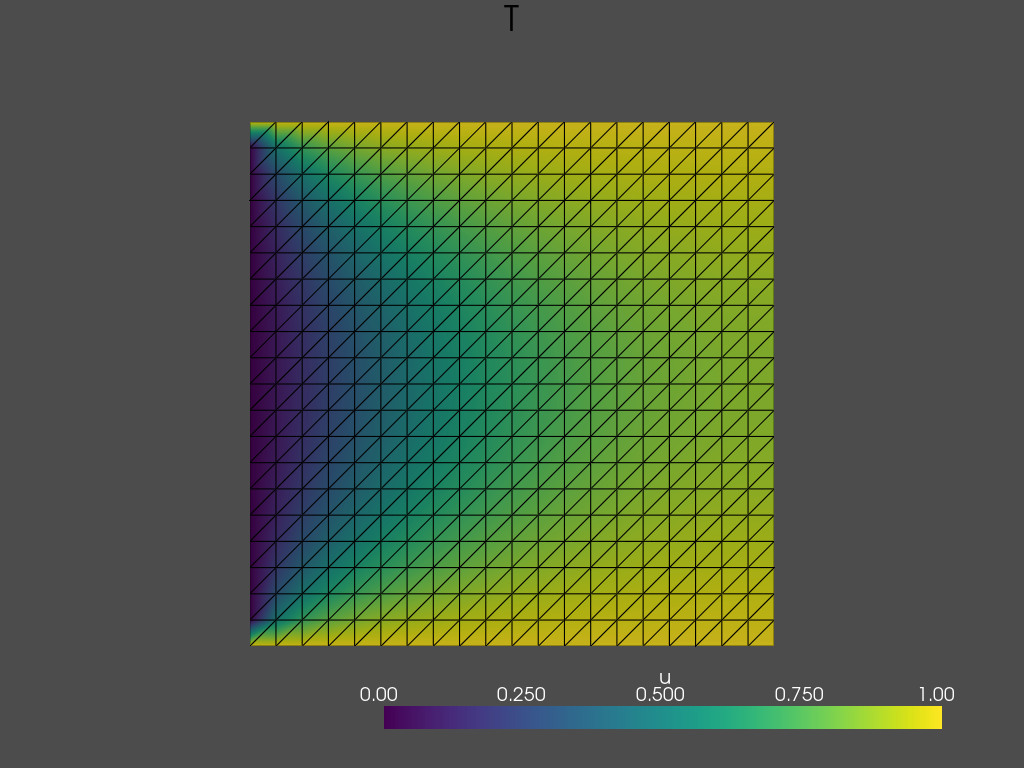

In [73]:
pyvista.start_xvfb()
from dolfinx.plot import create_vtk_mesh
pyvista_cells, cell_types, geometry = create_vtk_mesh(V)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
grid.point_data["u"] = T.x.array
grid.set_active_scalars("u")

plotter = pyvista.Plotter()
plotter.add_text("T", position="upper_edge", font_size=14, color="black")
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()

if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("neumann_dirichlet.png")



---

## Problem 1:


Diffusion-Advection of Temperature

$$\epsilon \nabla^2 T(\vec{x})=\mathbf{\beta}\cdot \nabla T(\vec{x})+q(\vec{x})
$$

$$
T(\vec{x})=1+x^2+2y^3
$$


on a unit square

use Dirichlet on all boundaries. 

(Hint: refer example 2)


---

